In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("directory_to_the_csv_file", index_col=0)

In [ ]:
df.iloc[0:5,0:5]

,AAK1,AASS,AATK,ABAT,ABCA1
GSM338860,6.170397,5.606532,8.186989,7.100655,4.965535
GSM338861,6.112532,5.407005,8.530366,7.131207,4.912667
GSM338863,6.164055,5.518116,7.642412,7.221282,4.962869
GSM338865,6.423721,5.650853,8.372038,7.381892,4.956469
GSM338866,6.631895,5.701830,7.903833,7.641011,4.991327


### Split df to X and Class to y

In [ ]:
# Separate features and target
X = df.drop(columns = ['Class'])
y = df['Class']

## Feature Selection: Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [ ]:
# Compute mutual information
mi = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

       Feature  Mutual Information
801      FOXG1            0.509560
1185      KLK8            0.503506
857        GDA            0.435089
1801     PTPN5            0.434184
1829    RAB40B            0.398203
...        ...                 ...
895      GNAI2            0.000000
1741  PPP1R14C            0.000000
909      GPM6A            0.000000
937      GRIK1            0.000000
1114     ITSN1            0.000000

[2525 rows x 2 columns]


In [ ]:
# Select top k features based on mutual information
k = 100  # Choose the number of top features you want
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

### 80/20 Rule

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

### Baseline Model

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics

In [ ]:
# Initial SVM
svm_model = SVC(kernel='rbf', C=1.0)  # You can choose 'linear', 'poly', 'rbf', etc. for the kernel
svm_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = svm_model.predict(X_test)
y_pred_train = svm_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Test Accuracy:", accuracy)
print("Train Accuracy:", train_accuracy)

Test Accuracy: 0.8493150684931506
Train Accuracy: 0.8546712802768166


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

print("Best parameters found: ", grid.best_params_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.544 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.586 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.586 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.579 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.569 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [ ]:
# SVM with optimal hyperparameters
svm_model = SVC(kernel='rbf', C=2, gamma=0.01)
svm_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = svm_model.predict(X_test)
y_pred_train = svm_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print("Test Accuracy:", accuracy)
print("Train Accuracy:", train_accuracy)

Test Accuracy: 0.9726027397260274
Train Accuracy: 0.9930795847750865


## Overfitting test

In [ ]:
# Calculate training accuracy
train_accuracy = accuracy_score(y_train, svm_model.predict(X_train))
print("Training Accuracy:", train_accuracy)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9930795847750865
Test Accuracy: 0.9726027397260274


### Confusion Matrix

In [ ]:
unique_labels = y.unique()
print(unique_labels)

['OPNA' 'TBI' 'EEV']


In [ ]:
# Define the class names based on the identified mapping
class_names = ['OPNA', 'TBI', 'EEV']

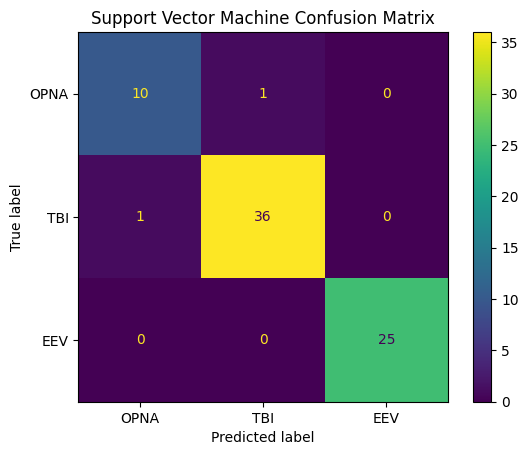

In [ ]:
# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(cmap=plt.cm.viridis)  # You can change the colormap if you prefer
plt.title("Support Vector Machine Confusion Matrix")
plt.show()

### Top 100 Features

In [ ]:
# Select the top 100 features based on mutual information
top_100_features = mi_df['Feature'].head(100)
top_100_features_df = X[top_100_features]

for column in top_100_features_df.columns:
    print(column)

FOXG1
KLK8
GDA
PTPN5
RAB40B
KLRD1
LHX2
SFMBT2
KLF16
GCLM
IL12B
BCL11B
B3GNT5
OXNAD1
SHOX2
MAS1
MEIS1
FGL2
SLC25A23
DLX5
KCNE2
ABR
DPYSL4
ARX
TFPI2
DMP1
CD28
SOSTDC1
ICAM5
CHST1
SHF
MMP24
IFIT1
CD86
CST6
NETO1
HES5
SNX15
TTR
GRIN2C
SNCA
GIMAP4
ITPR1
PDE2A
DBN1
AKAP12
SDC1
PTK2B
ENC1
ACSL5
EPHA4
KCNA4
TBR1
HEBP1
EPHA6
CEBPD
RGS14
EN2
SAT1
BASP1
MYO5B
LMO7
PDE1A
DAB2IP
SOCS3
COMP
KL
CADPS2
FOSL2
FEZF2
ITGBL1
MICAL1
FOLR1
PFN2
PKP2
CX3CL1
ITPKA
MAL2
NEK6
KCTD4
NPY1R
MYC
RASL10A
LIG1
IL16
SOX4
PCDH8
TRPC4
INPP1
PRC1
PARD6A
CHRNA6
CHRNA5
CPE
VIP
KCNJ4
ILF3
MAB21L2
SELL
IL6
